In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs #running this code is going to clone our repository and will allow us to import our traffic sign data

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [0]:
!ls german-traffic-signs #show the files that this packet contains

signnames.csv  test.p  train.p	valid.p


In [0]:
#PREPOCESSING IMAGES
%tensorflow_version 1.x
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle 
import pandas as pd #import pandas to manipulate the csv files
import random

In [0]:
np.random.seed(0)

In [0]:
#we will open the files train.p, valid.p and test.p
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

X_train = np.asarray([train_data['features'][n] for n in range(len(train_data['features'])) if train_data['labels'][n] == 0 or  train_data['labels'][n] == 7 or train_data['labels'][n] == 12 or train_data['labels'][n] == 14 or train_data['labels'][n] == 18])
X_val = np.asarray([val_data['features'][n] for n in range(len(val_data['features'])) if val_data['labels'][n] == 0 or  val_data['labels'][n] == 7 or val_data['labels'][n] == 12 or val_data['labels'][n] == 14 or val_data['labels'][n] == 18])
X_test = np.asarray([test_data['features'][n] for n in range(len(test_data['features'])) if test_data['labels'][n] == 0 or  test_data['labels'][n] == 7 or test_data['labels'][n] == 12 or test_data['labels'][n] == 14 or test_data['labels'][n] == 18])

lista = [0, 7, 12, 14, 18]
y_train = np.asarray([x for n in range(len(train_data['labels'])) for x in range(len(lista)) if np.any(train_data['labels'][n] == lista[x])])
y_val = np.asarray([x for n in range(len(val_data['labels'])) for x in range(len(lista)) if np.any(val_data['labels'][n] == lista[x])])
y_test = np.asarray([x for n in range(len(test_data['labels'])) for x in range(len(lista)) if np.any(test_data['labels'][n] == lista[x])])

#y_train = np.asarray([train_data['labels'][n] for n in range(len(train_data['labels'])) if train_data['labels'][n] == 0 or  train_data['labels'][n] == 7 or train_data['labels'][n] == 12 or train_data['labels'][n] == 14 or train_data['labels'][n] == 22])
#y_val = np.asarray([val_data['labels'][n] for n in range(len(val_data['labels'])) if val_data['labels'][n] == 0 or  val_data['labels'][n] == 7 or val_data['labels'][n] == 12 or val_data['labels'][n] == 14 or val_data['labels'][n] == 22])
#y_test = np.asarray([test_data['labels'][n] for n in range(len(test_data['labels'])) if test_data['labels'][n] == 0 or  test_data['labels'][n] == 7 or test_data['labels'][n] == 12 or test_data['labels'][n] == 14 or test_data['labels'][n] == 22])

In [0]:
print(X_train.shape) #shows the structure of our data
print(X_val.shape)
print(X_test.shape)
#the first argument is the amount of images, the second and third argument shows the dimension in pixels of each image
#the number three in the last argument is because traffic signs images are in RBG format and has an additional depth for each of the three color chanels (red, green, blue)

(5130, 32, 32, 3)
(600, 32, 32, 3)
(1860, 32, 32, 3)


In [0]:
#we have to ensure that the images concur with the labels
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
#we are going to ensure that the size of our image is indeed 32 by 32 with a depth of three chanels as expected
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"


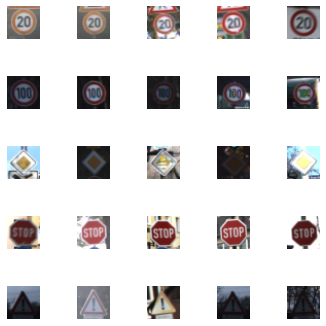

In [0]:
#The file signnames.csv contains all of the traffic sign classes and any file as saw earlier
#print(data) #we can see the traffic sign with its respective class
num_of_samples = []
 
cols = 5
num_classes = 5

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 5)) #grid
fig.tight_layout()
for i in range(cols):
    for j in range(cols):
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            #axs[j][i].set_title(str(j) + "-" + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1290, 1890, 690, 1080]


Text(0, 0.5, 'Number of images')

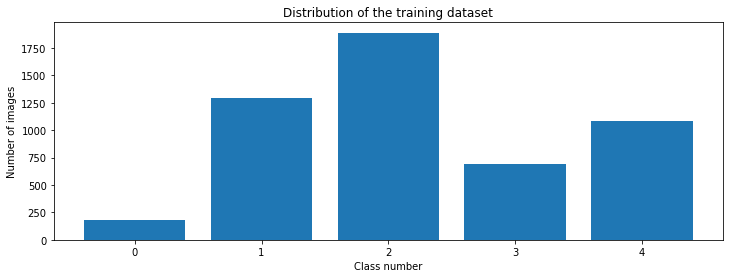

In [0]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
4


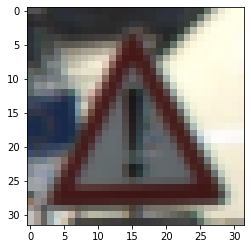

In [0]:
#before we can design and train our model, we need to preprocess our data to make it easier for our network to classify them, because now we have more complex signs
import cv2
#this is just to check if any image concur with its label and with its dimension
plt.imshow(X_train[1000]) #feel free to put whatever image you want
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


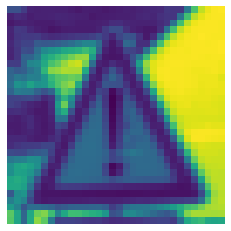

In [0]:
#convert our image to grayscale, why?
#because color is not a very significant feature to look for. The lighting in our image varies and many of the traffic signs 
#of similar colors. The features of the signs that really matter are the edges, the curves, etc.
#Also by converting rgb into grayscale, we reduce the depth of our image from three to one, this means that our network now requiers fewer parameters as our input data will only have a depth of one chanel
#So our network will be much more efficient and will requiere less computing power to classify our data. 
def grayscale(img):
  imagen = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return imagen

img = grayscale(X_train[1000])

plt.imshow(img)
plt.axis('off')
print(img.shape) #now we see that is a two dimensional array

(32, 32)


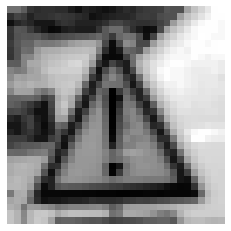

In [0]:
#Now we will use the historiam equalization to increase contrast and the more defined features making it easier to our neural network to learn and extract these features
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap=plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  #another prepocesing technique called normalization that consist in divide all the pixels intensities of our image by 255
  img = img / 255
  return img

X_train = np.array(list(map(preprocessing, X_train))) #to ensure that all of our training images prepocess correctly 
#where each image from the array X_train will go into the function as a parameter is preprocess and then returned as the updated value of the array
X_val = np.array(list(map(preprocessing, X_val))) #we can process our validation and test data as well
X_test = np.array(list(map(preprocessing, X_test)))

(5130, 32, 32)


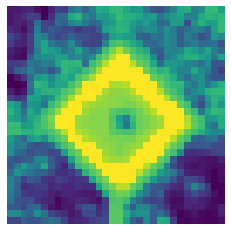

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)]) #plot a prepocess image of the training images
plt.axis('off')
print(X_train.shape)

In [0]:
X_train = X_train.reshape(5130, 32, 32, 1)
X_test = X_test.reshape(1860, 32, 32, 1)
X_val = X_val.reshape(600, 32, 32, 1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
#this class will allow us to define the types of transformations we want to make to our data sets
#it will also allow us to set range limits for just how extreme these transformations can get
datagen = ImageDataGenerator(width_shift_range = 0.1, 
                   height_shift_range = 0.1,
                   zoom_range = 0.2,
                   shear_range = 0.1,
                   rotation_range = 10)
datagen.fit(X_train)

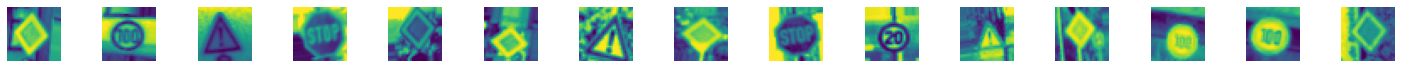

In [0]:
batches = datagen.flow(X_train, y_train, batch_size = 20) #we have created an iterator which stores a batch of 20 images along with their respective labels
X_batch, y_batch = next(batches) #the function next() simply calls an iterator item and retrieves the next item for it
#As we defined our iterator to create a batch size of 20 we get 20 new images each time the next function is called on the iterator
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [0]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(5130, 32, 32, 1)
(1860, 32, 32, 1)
(600, 32, 32, 1)


In [0]:
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)
y_val = to_categorical(y_val, 5) #we have succesfully process our data and we are now ready to use our data to train and validate our convolutional neural network

In [0]:
def leNet_model():
  model = Sequential()
  model.add(Conv2D((30), (5, 5), input_shape=(32, 32, 1), activation='relu')) #30 kernels or filters of 5x5
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(15, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size= (2,2)))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation = 'relu'))
  #model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax')) #define the output layer
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model


In [0]:
model = leNet_model()
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 540)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               54100     
______________________________________

In [0]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch = 2000, epochs = 4, validation_data=(X_val, y_val))
#history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)


Epoch 1/4
2000/2000 [==============================] - 38s 19ms/step - loss: 0.1506 - accuracy: 0.9471 - val_loss: 0.0550 - val_accuracy: 0.9850
Epoch 2/4
2000/2000 [==============================] - 31s 16ms/step - loss: 0.0210 - accuracy: 0.9936 - val_loss: 0.0338 - val_accuracy: 0.9900
Epoch 3/4
2000/2000 [==============================] - 31s 16ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.0853 - val_accuracy: 0.9883
Epoch 4/4
2000/2000 [==============================] - 32s 16ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.0457 - val_accuracy: 0.9883


Text(0.5, 0, 'epoch')

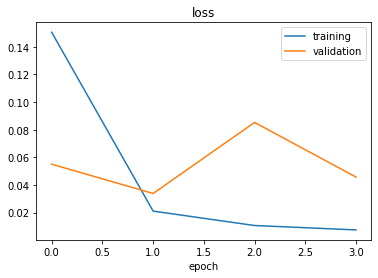

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

In [0]:
score = model.evaluate(X_test, y_test, verbose = 0)
print("Test Score: ", score[0])
print('Test Accuracy:', score[1])
#IMPORTANT
#Why if we add more convolutional layers to our network and increase the number of filters,
#the number of parameters decreases and the accuracy increases??
#Well, the reason for this is the fact that with each convolutional layer, the dimensions of our image decrease
#this means that by that time our image reaches over fully conected layers it has much smaller dimensions.
#This results in fewer parameters within the fully connected layer, which results in less overall paramenters tithin their model
#Therefore with this new modification our model will require less computing power and will potentially improve our accuracy.


Test Score:  0.0375167936564247
Test Accuracy: 0.9908602237701416


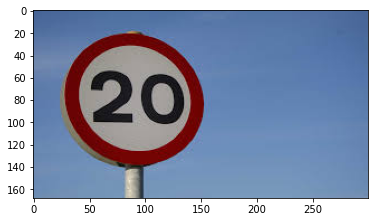

In [0]:
import requests
from PIL import Image
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTOxAjrLOtNV2WLeu1iHattvVEo84ws6lKuWKSkCCO8GATSZxld&usqp=CAU'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


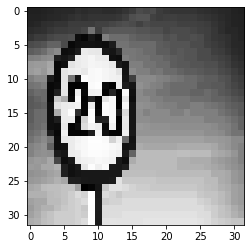

In [0]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 

In [0]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [0]


In [0]:
model.save('model_signs_3.h5')

In [0]:
from google.colab import files
files.download('model_signs_3.h5')